## Before you turn this coursework in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

In [1]:
NAME = "Z0194160"
CIS_USERNAME = "bqxt46"

---

# COMP42415 Text Mining and Language Analytics
## Coursework 2023-24

### Instructions:

- <ins>**DO NOT RENAME THIS JUPYTER NOTEBOOK !!!**</ins>
- Please write the answers for each question in the respective cell. 
- You can add more cells if needed.
- If needed, you can upload additional files, e.g. pre-trained word embeddings, in the coursework's directory
- You can safely remove the `raise NotImplementedError()` line from each code cell.
- You can find information about markdown syntax from [here](https://www.markdownguide.org/basic-syntax/#emphasis).

## Implementation - Task 1
Prepare the dataset by applying any pre-processing or cleaning steps that you consider as necessary. Then, split the dataset into a training set containing 70% of the samples and a test set containing 30% of the samples. Follow an appropriate strategy for the split. You must use these training/test sets for all the models in this coursework. (**10%**)

In [2]:
## Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk import word_tokenize, sent_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
import tensorflow.keras
import pickle
import random

## Set Seed For Reproducibility
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

<ipython-input-2-d7ac29422cc9>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Unprocessed Food Reviews
Total Rows:	 540031
Total Columns:	 3
Duplicated Rows: 162009 (30.00%)

Remove Duplicated Food Reviews
Total Rows:	 378022
Total Columns:	 3

Missing Values in Each Column Check
Score      0
Summary    3
Text       0
dtype: int64


,Score,Summary,Text
17424,2,NaN,I only used two maybe three tea bags and got p...
365628,3,NaN,I like the product and tried it before I pucha...
525663,3,NaN,This is a cool system only problem is that the...



Remove Missing Values Food Reviews
Total Rows:	 378019
Total Columns:	 3


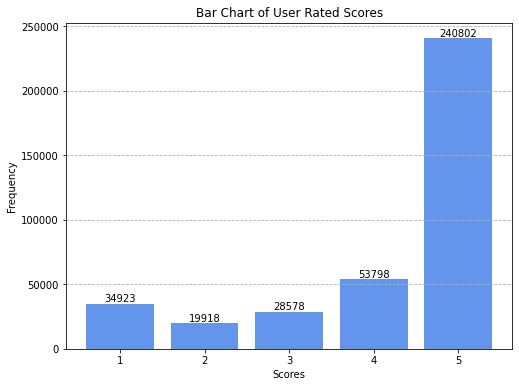

In [3]:
## Import Files
food_reviews_df = pd.read_csv("food_reviews.csv")

## Data Set Evaluation
duplicated_rows = food_reviews_df.duplicated(subset = ["Score", "Summary", "Text"]) # Duplicate = rows have same column values
print("Unprocessed Food Reviews")
original_nrows = food_reviews_df.shape[0] # Number of rows
original_ncols = food_reviews_df.shape[1] # Number of columns
print("Total Rows:\t", original_nrows)
print("Total Columns:\t", original_ncols)

## Check Data Duplication and Removal
print("Duplicated Rows: %4d (%2.2f%s)" % 
      (duplicated_rows.sum(), round(duplicated_rows.sum() / original_nrows * 100,2), "%"))
no_duplicates_df = food_reviews_df.drop_duplicates(subset = ["Score", "Summary", "Text"], 
                                                   keep = "first", inplace = False)
print("\nRemove Duplicated Food Reviews")
print("Total Rows:\t", no_duplicates_df.shape[0])
print("Total Columns:\t", no_duplicates_df.shape[1])

## Missing Value Check and Removal
print("\nMissing Values in Each Column Check")
print(no_duplicates_df.isnull().sum()) # Check for missing values in each column
missing_rows = no_duplicates_df[no_duplicates_df.isnull().any(axis=1)] # Filter only rows with missing values
display(missing_rows) # Visualize missing rows
pre_processed_reviews_df = no_duplicates_df.dropna()
print("\nRemove Missing Values Food Reviews")
print("Total Rows:\t", pre_processed_reviews_df.shape[0])
print("Total Columns:\t", pre_processed_reviews_df.shape[1])

## Visualize Score Distribution
rated_score_count = pre_processed_reviews_df['Score'].value_counts() # Count all the values

plt.figure(figsize=(8, 6)) # Create a figure
bar_plot = plt.bar(rated_score_count.index, rated_score_count.values, color="cornflowerblue")
for a_bar in bar_plot: # add in the count for each score
    bar_height = a_bar.get_height()
    plt.text(a_bar.get_x() + a_bar.get_width() / 2, 
             bar_height, bar_height, ha="center", va="bottom") # Add in the count into the plot

plt.title("Bar Chart of User Rated Scores")
plt.xlabel("Scores")
plt.ylabel("Frequency")
plt.grid(axis = "y", linestyle = "--", alpha=1) # line guide
plt.show(); 

In [4]:
## Select a percentage of the data while maintaining the class imbalance
pct_data = 0.15
grouped_df = pre_processed_reviews_df.groupby("Score", group_keys=False) # Group by Score
subset_data_df = pd.DataFrame()
for score in pre_processed_reviews_df["Score"].unique():
    grouped_score = pre_processed_reviews_df[pre_processed_reviews_df["Score"] == score]
    score_class_n = len(grouped_score) # number of data for that score class
    number_of_samples = int(score_class_n * pct_data) # Convert to int
    sampled_group = grouped_score.sample(n = number_of_samples, # Get that percentage from the data
                                         random_state = SEED)
    print("Original Data Size:", score_class_n, "\tSubset of Data:", number_of_samples, "\tPercentage", str(round((number_of_samples/score_class_n*100), 2))+" %")
    subset_data_df = pd.concat([subset_data_df, sampled_group], ignore_index = True)

## We need to reshuffle the data to simulate original dataset which is not sorted
shuffled_subset_df = subset_data_df.sample(frac = 1, random_state = SEED).reset_index(drop = True) # Reshuffle the data

Original Data Size: 240802 	Subset of Data: 36120 	Percentage 15.0 %
Original Data Size: 28578 	Subset of Data: 4286 	Percentage 15.0 %
Original Data Size: 34923 	Subset of Data: 5238 	Percentage 15.0 %
Original Data Size: 53798 	Subset of Data: 8069 	Percentage 15.0 %
Original Data Size: 19918 	Subset of Data: 2987 	Percentage 15.0 %


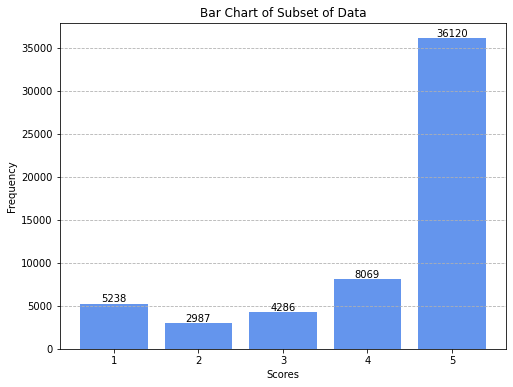

In [5]:
## Visualize the Subset Distribution
subset_count = shuffled_subset_df["Score"].value_counts() # Count all the values

plt.figure(figsize=(8, 6)) # Create a figure
bar_plot = plt.bar(subset_count.index, subset_count.values, color="cornflowerblue")
for a_bar in bar_plot: # add in the count for each score
    bar_height = a_bar.get_height()
    plt.text(a_bar.get_x() + a_bar.get_width() / 2, 
             bar_height, bar_height, ha = "center", va = "bottom") # Add in the count into the plot

plt.title("Bar Chart of Subset of Data")
plt.xlabel("Scores")
plt.ylabel("Frequency")
plt.grid(axis = "y", linestyle = "--", alpha = 1) # line guide
plt.show();

In [6]:
## Combine Summary and Text Data Into "Combined Review"
def combine_summary_text(summary, text):
    """
    This function joins summary and text together. 
    The summary is treated as a sentence by adding a dot "." in the back if it does not already exist.
    """
    combined_text = "" # string variable
    if summary.endswith("."):
        combined_text = summary.strip() + " " + text.strip()
    else:
        combined_text = summary.strip() + ". " + text.strip()
    return combined_text

## Create Combined Review DataFrame
nrows = shuffled_subset_df.shape[0]
for row_n in range(nrows):
    review_summary = shuffled_subset_df.iloc[row_n,1]
    review_text = shuffled_subset_df.iloc[row_n,2]
    combined_text = combine_summary_text(review_summary, review_text) # Combined the summary and text
    shuffled_subset_df.at[row_n, "combined_review"] = combined_text
display(shuffled_subset_df.head(5))

,Score,Summary,Text,combined_review
0,2,Not up to my expectation,You get what you pay for... I was excited to ...,Not up to my expectation. You get what you pay...
1,5,Truly Premium Coffee,Being from Puerto Rico I took for granted the ...,Truly Premium Coffee. Being from Puerto Rico I...
2,5,A great time saver for the baker,I was using this many years ago and couldn't f...,A great time saver for the baker. I was using ...
3,5,loooove it,"My whole family loooves this cereal, either al...",loooove it. My whole family loooves this cerea...
4,3,Romulan Ale Energy Drink,None of these questions really pertain; this w...,Romulan Ale Energy Drink. None of these questi...


In [7]:
## Import libraries
from sklearn.model_selection import train_test_split

## Startified Split
label_scores = shuffled_subset_df["Score"] # y
review_text = shuffled_subset_df["combined_review"] # X


## Divide into Training and Testing
X_train_unprocessed, X_test_unprocessed, Y_train, Y_test = train_test_split(review_text,
                                                    label_scores,
                                                    test_size = 0.3,
                                                    random_state = SEED, 
                                                    stratify = label_scores)

## Evaluate the Train and Test Split
n_training_samples = len(X_train_unprocessed)
n_testing_samples = len(X_test_unprocessed)
n_total_samples = n_training_samples + n_testing_samples

## Print it out
print("Training and Testing Split")
print("Total samples:\t\t%4d" % n_total_samples)
print("Training samples:\t%4d (%2.2f%s)" % (n_training_samples,(n_training_samples/n_total_samples )*100,"%"))
print("Test samples:\t\t%4d (%2.2f%s)" % (n_testing_samples ,(n_testing_samples /n_total_samples )*100,"%"))

Training and Testing Split
Total samples:		56700
Training samples:	39690 (70.00%)
Test samples:		17010 (30.00%)


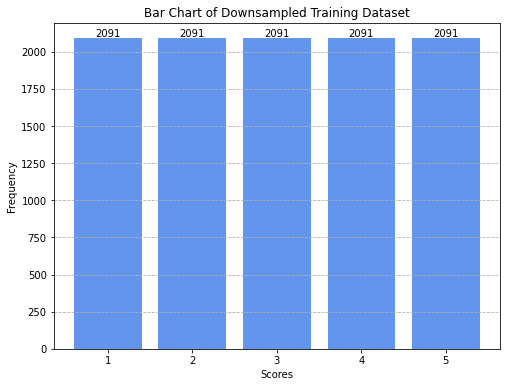

In [8]:
## Downsampling to deal with class imbalance
train_df = pd.concat([X_train_unprocessed, Y_train], axis=1) # Combine

grouped_df = train_df.groupby("Score", group_keys = False) # Group by Score
balanced_df = pd.DataFrame()  # Place holder for new dataframe
minimum_class_count = train_df["Score"].value_counts().min() # Resample to reach the lowest class number

## Group by Score to Downsampling to reach minimun class number
for score in train_df["Score"].unique(): # loop through unique score values
    grouped_score = train_df[train_df["Score"] == score]
    sampled_group = grouped_score.sample(n = minimum_class_count, random_state = SEED) # For reporducibility
    balanced_df = pd.concat([balanced_df, sampled_group], ignore_index=True) # Concat it into the new dataframe

## We need to reshuffle the data to simulate original dataset which is not sorted
shuffled_balanced_df = balanced_df.sample(frac = 1, random_state = SEED).reset_index(drop = True) # Reshuffle the data

## Visualized Balanced Class Data
balance_rate_count = shuffled_balanced_df["Score"].value_counts() # Count all the values

plt.figure(figsize=(8, 6)) # Create a figure
bar_plot = plt.bar(balance_rate_count.index, balance_rate_count.values, color="cornflowerblue")
for a_bar in bar_plot: # add in the count for each score
    bar_height = a_bar.get_height()
    plt.text(a_bar.get_x() + a_bar.get_width() / 2, 
             bar_height, bar_height, ha = "center", va = "bottom") # Add in the count into the plot

plt.title("Bar Chart of Downsampled Training Dataset")
plt.xlabel("Scores")
plt.ylabel("Frequency")
plt.grid(axis = "y", linestyle = "--", alpha = 1) # line guide
plt.show();

In [9]:
## Data Cleaning Functions
def remove_emails(text):
    email_regex = r"[a-zA-Z0-9._+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}"
    clean_text = re.sub(email_regex, " ", text) # remove emails
    return clean_text
    
def remove_html_tags(text):
    clean_text = re.sub("<.*?>", " ", text)  # remove tags such as <a></a>
    return clean_text

def remove_urls(text):
    web_url = r"(https?:\/\/|www\.){0,1}[a-zA-Z0-9]{2,}\.[a-zA-Z0-9]{2,}\S*"
    clean_text = re.sub(web_url, " ", text) # remove website starts with www. | http: | https:
    return clean_text

def expand_contract_word(text):
    """
    This function expands common word contraction for English language.
    It will make the sentence into lower case to ensure consistency.
    For instance, "It's" -> "it is".
    """
    clean_text = text# Ensure consistency
    
    ## Specific Contractions
    ## With change in word form OR slight word modification
    clean_text = re.sub("won\'t", "will not", clean_text) # I won't -> i will not
    clean_text = re.sub("can\'t", "can not", clean_text) # I can't -> i can not
    clean_text = re.sub("shan\'t", "shall not", clean_text) # I shan't -> i shall not
    clean_text = re.sub("'cause", " because", clean_text) # 'cause -> because
    
    ## Without change in word form: couldn't, aren't,...
    clean_text = re.sub("n\'t", " not", clean_text)
    
    ## Present Tense Contraction 
    clean_text = re.sub("\'s", " is", clean_text) # It's -> it is [Generalize possible to be "has"]
    clean_text = re.sub("\'m", " am", clean_text) # I'm -> i am
    clean_text = re.sub("\'re", " are", clean_text) # They're -> they are
    
    ## Past Tense Contractraction
    clean_text = re.sub("\'ve", " have", clean_text) # I've -> i have
    
    ## Future Tense Contraction
    clean_text = re.sub("\'ll", " will", clean_text) # I'll -> i will
    clean_text = re.sub("\'d", " would", clean_text) # I'd -> i would
    
    ## Return the decontracted phrase
    return clean_text

def star_replacer(match):
    """
    Function to use alongside star rating to text.
    """
    score_range = {1: "one", 2: "two", 3: "three", 4: "four", 5: "five", 
                   10: "ten"}
    num = int(match.group(1))  # Extract the captured number from the match
    if num in score_range:
        if num == 1: # If its a 1 star case
            return score_range[num] + " star" # Singular
        else:
            return score_range[num] + " stars"  # Plural Stars
    else:
        return str(num) + " stars"  # Other cases

def star_rating_to_text(text):
    """
    Capture user rating range is 1 to 5, common wording is 1 star, 2 stars or 5 stars.
    10 stars is used for 5 stars product.
    """
    rating_regex = r"(1?[0-9])\s?[Ss]tars?" #Number follow by stars or star
    transformed_text = re.sub(rating_regex, star_replacer, text)
    return transformed_text

def text_cleaner(text):
    """
    This function combines all the text cleaning functions.
    """
    clean_text = remove_emails(text)
    clean_text = remove_html_tags(clean_text)
    clean_text = remove_urls(clean_text)
    clean_text = star_rating_to_text(clean_text)
    clean_text = expand_contract_word(clean_text)
    return clean_text

## Word Lemmatizer
def penn_to_wordnet(penn_pos_tag):
    tag_dictionary = {'NN':'n', 'JJ':'a','VB':'v', 'RB':'r'}
    try:
        return tag_dictionary[penn_pos_tag[:2]]
    except:
        return 'n' # No mapping -> return default
    
def text_processing(review_text):
    """
    This function combines text cleaning process (removal of html tags and urls, expand contracted words)
    with lemmatization by word tagging and returing a formatted text.
    """
    ## Loading Functions and Resources from libraries
    wnl = WordNetLemmatizer() # we need to lemmatize with part of speech type as adjective describes noun = the product
    punc_list = list(punctuation) # load punctuation list
    stopwords_english = set(stopwords.words('english')) # load english stopwords
    negative_stopwords = set(['no', 'nor', 'not', 'off']) # Stopwords to keep
    updated_stopwords = stopwords_english - negative_stopwords # Stopwords to consider, set is used for ease of removal
    
    clean_text = text_cleaner(review_text) # clean the text
    processed_review_text = list() # holder for a review
    for sent in sent_tokenize(clean_text): # Tokenize as a sentence
        tag_sentence = pos_tag(word_tokenize(sent)) # Give the sentences tagging
        for word, tag in tag_sentence:
            word = word.replace("-", "") # round-trip -> roundtrip
            word = word.replace(".", "") # U.S. -> US
            word = word.lower() # Change to lowercase
            word_matcher = re.match("[a-z]+", word) # a word should only be a list of characters
            if (word_matcher != None):
                if(word_matcher.group() == word): # If the detected word is the same with regex
                    ## A word should be two characters or more (e.g. no) and punctuation and not in the list of stop words 
                    if (len(word)>=2) and (word not in punc_list) and (word not in updated_stopwords):
                        processed_review_text.append(wnl.lemmatize(word, pos=penn_to_wordnet(tag)))

    cleaned_formatted_text = " ".join(processed_review_text) # join the text back
    
    return cleaned_formatted_text.strip()

In [10]:
## Display the Downsampled File
display(shuffled_balanced_df.head(5))
print("Balanced Training Data:", len(shuffled_balanced_df), "reviews.") # Display the size

## Apply Cleaning After Seprating to reduce runtime
## We apply it after as the dataset is smaller
shuffled_balanced_df["processed_review"] = shuffled_balanced_df["combined_review"].apply(text_processing)

## Apply to the Testing Set
X_test = X_test_unprocessed.apply(text_processing)

## Display the DataFrame
display(shuffled_balanced_df.head(5))

## Separate Again to Data Series
X_train = shuffled_balanced_df["processed_review"]
Y_train = shuffled_balanced_df["Score"]

,combined_review,Score
0,"Defective cups. Like the flavor, but at least ...",2
1,really expencive jar of pure unopposed human e...,2
2,Wonderful spices. I love the taste of this ras...,5
3,Best way to buy kcups. Once you've tried some ...,5
4,Amazing !!. I absolutely love this chai mix. I...,5


Balanced Training Data: 10455 reviews.


,combined_review,Score,processed_review
0,"Defective cups. Like the flavor, but at least ...",2,defective cup like flavor least third cup come...
1,really expencive jar of pure unopposed human e...,2,really expencive jar pure unopposed human excr...
2,Wonderful spices. I love the taste of this ras...,5,wonderful spice love taste ras el hanout rice ...
3,Best way to buy kcups. Once you've tried some ...,5,best way buy kcups try random sampler pack ove...
4,Amazing !!. I absolutely love this chai mix. I...,5,amazing absolutely love chai mix try mix favor...


In [11]:
## View the Cleaning Process
sample_number = 0

## Train Group
print("-" * 50)
print("Train Sample Score:", Y_train.iloc[sample_number])
print("-" * 50)
print("Train Sample Before Cleaning:\n" + shuffled_balanced_df["combined_review"][sample_number]+"\n")
print("Train Sample After Cleaning:\n" + shuffled_balanced_df["processed_review"][sample_number]+"\n")

## Test Group
print("-" * 50)
print("Test Sample Score:", Y_test.iloc[sample_number])
print("-" * 50)
print("Test Sample Before Cleaning:\n" + X_test_unprocessed.iloc[sample_number]+"\n")
print("Test Sample After Cleaning:\n" + X_test.iloc[sample_number])

--------------------------------------------------
Train Sample Score: 2
--------------------------------------------------
Train Sample Before Cleaning:
Defective cups. Like the flavor, but at least a third of the cups have come unsealed during brewing, spewing coffee all over my counter and leaving an undrinkable ground filled mess in my coffee cup.

Train Sample After Cleaning:
defective cup like flavor least third cup come unsealed brewing spew coffee counter leave undrinkable ground fill mess coffee cup

--------------------------------------------------
Test Sample Score: 4
--------------------------------------------------
Test Sample Before Cleaning:
Good variety. I liked these samplers. I got a very good variety of flavors and only a handful of doubled flavors. Packaging was good, no broken cups. I would buy this again.

Test Sample After Cleaning:
good variety like sampler get good variety flavor handful doubled flavor packaging good no broken cup would buy


In [12]:
## Encode Label Data for Neural Networks
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

## Implementation - Task 2
Implement a Naïve Bayes model for predicting the rating of a food review. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**5%**)

In [13]:
## Import Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

## Task: 2.0 Implementation of Naive Bayes Model
## Goal: predict food review rating

nb_model = make_pipeline(TfidfVectorizer(), MultinomialNB())

nb_model.fit(X_train, Y_train) # Create a Naive Bayes Model
nb_pred_scores = nb_model.predict(X_test) # Predict

## Viewing the model Prediction
print("Naive Bayes Model")
print("Predicted:", nb_pred_scores.tolist()[0:10])
print("Ground truth:", Y_test.tolist()[0:10])

Naive Bayes Model
Predicted: [4, 2, 4, 4, 5, 5, 3, 1, 4, 5]
Ground truth: [4, 1, 5, 4, 1, 5, 3, 4, 5, 5]


In [14]:
## Save File: Task 7
import pickle

nb_model_file_name = "naive_bayes_model.pkl"
with open(nb_model_file_name, "wb") as file:
    pickle.dump(nb_model, file)

## Implementation - Task 3
Implement a k-Nearest Neighbours model for predicting the rating of a food review. Train your model on the training set and test it on the test set. Use an appropriate text representation. You must select the best k by examining the performance of the model for $k \in \{1,3,5,7\}$, using an appropriate cross-validation approach. Create a plot for k vs. classification performance to justify your choice. (**10%**)

K-Neighbours: 1 CV Accuracy: 0.2846
K-Neighbours: 3 CV Accuracy: 0.2827
K-Neighbours: 5 CV Accuracy: 0.3018
K-Neighbours: 7 CV Accuracy: 0.3074


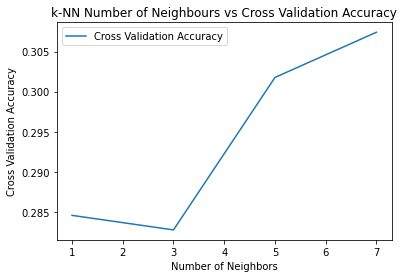

In [15]:
## Import libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

## Task: 3.0 Implementation of k-Nearest Neighbours Model
## Goal: predict food review rating

## 3.1 Evaluate: k = (1,3,5,7) and select the best k
k_values = [1, 3, 5, 7]
pred_cv_scores = list()

for k in k_values:
    np.random.seed(SEED) ## Set Seed for Each Loop
    knn_model = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors = k))
    cv_score = cross_val_score(knn_model, X_train, Y_train, 
                               cv = 3, scoring = "accuracy")
    mean_cv_score = cv_score.mean() # Mean of the 3 CV in each k-NN model
    print("K-Neighbours: " + str(k) + " CV Accuracy: " + str(round(mean_cv_score, 4)))
    pred_cv_scores.append(mean_cv_score)
    
## 3.2 Plot k vs classification performance
import matplotlib.pyplot as plt

## Plot varying k-NN Number of Neighbours
plt.plot(k_values, pred_cv_scores, label = "Cross Validation Accuracy")
plt.legend() # Add legend
plt.title("k-NN Number of Neighbours vs Cross Validation Accuracy")
plt.xlabel("Number of Neighbors")
plt.ylabel("Cross Validation Accuracy")
plt.show();

In [16]:
## 3.3 Build the best KNN model
## Train and test with full data
best_k = k_values[pred_cv_scores.index(max(pred_cv_scores))] # Get the best accuracy k value

best_knn_model = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors = best_k))
best_knn_model.fit(X_train, Y_train)
knn_pred_scores = best_knn_model.predict(X_test) # Predict
print("k-NN Model")
print("Predicted:", knn_pred_scores.tolist()[0:10])
print("Ground truth:", Y_test.tolist()[0:10])

k-NN Model
Predicted: [2, 2, 2, 3, 5, 4, 3, 1, 1, 3]
Ground truth: [4, 1, 5, 4, 1, 5, 3, 4, 5, 5]


In [17]:
## Save File: Task 7
import pickle

knn_model_file_name = "knn_model.pkl"
with open(knn_model_file_name, "wb") as file:
    pickle.dump(best_knn_model, file)

## Implementation - Task 4
Implement a Convolutional Neural Network (CNN) model for predicting the rating of a food review. The model must have at least two convolutional layers. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**13%**)

In [18]:
## CNN Model will be using Pre-trained Embeddings
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization
import numpy as np
import pickle

## Define Hyper Parameters
MAX_VOCABULARY_WORDS = 5000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 50
SCORE_CLASSES = 5 # Predictor Classes

## Initializer Tokenizer "Training Tokenizer"
tokenizer = Tokenizer(num_words = MAX_VOCABULARY_WORDS)
tokenizer.fit_on_texts(X_train)
word_indexes = tokenizer.word_index

## As we are using the tokenizer which is fit on the training for future models
tokenizer_file_name = "tokenizer.pkl"
with open(tokenizer_file_name, "wb") as file:
    pickle.dump(tokenizer, file)
file.close()

## Convert text into sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

## Add Padding to make uniform length
X_train_padded = pad_sequences(X_train_sequences, 
                               maxlen = MAX_SEQUENCE_LENGTH, 
                               padding = "post")
X_test_padded = pad_sequences(X_test_sequences, 
                              maxlen = MAX_SEQUENCE_LENGTH, 
                              padding = "post")

## Vectorize Training Vocabulary
## Text -> Vocabulary Vector
vectorizer = TextVectorization(max_tokens = MAX_VOCABULARY_WORDS,
                                   output_sequence_length = MAX_SEQUENCE_LENGTH)
vectorizer.adapt(X_train)
vocabulary = vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary)))) # Create Indexes of words
print("Vocabulary size: " + str(len(vocabulary)) + " words.")

## Load Pre-trained Embeddings
## File is in the submission directory
embeddings_dict = {}
with open("glove.6B.50d.txt", "r") as file:
    counter = 1
    for line in file: # Each Line represent a vector of embeddings
        values = line.split() # Turn into a list
        word = values[0] # Get word
        vector = np.asarray(values[1:], "float32") # 1: end = embeddings
        embeddings_dict[word] = vector # Add into the dict

file.close() # Close the file

## Create Embedding Dict
hits = 0 # Word Exist in the Embedding
misses = 0 # Word Does not Exist in the Embedding
embedding_matrix = np.zeros((len(word_indexes) + 1, EMBEDDING_DIM))
for word, idx in word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        hits += 1
    else:
        misses += 1
        
vocab_size = embedding_matrix.shape[0]
print("Converted %d words (%d misses)" % (hits, misses))

Vocabulary size: 5000 words.
Converted 4858 words (142 misses)


In [19]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Input, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Dense, Dropout, BatchNormalization

## Define the Model
cnn_model = Sequential(name="CNN_model")

## Input Layer
cnn_model.add(Input(shape = (MAX_SEQUENCE_LENGTH,), dtype = tf.int32))

## Embedding Layer:
embedding_layer = Embedding(
    input_dim = vocab_size,
    output_dim = EMBEDDING_DIM,
    input_length = MAX_SEQUENCE_LENGTH,
    weights = [embedding_matrix],  # Pre-trained Embeddings
    trainable = False 
)
cnn_model.add(embedding_layer)

## Hidden Layers: Convolution Neural Network
cnn_model.add(Conv1D(filters=64, kernel_size = 3, padding = "same", activation = "relu"))
cnn_model.add(Conv1D(filters=64, kernel_size = 3, padding = "same", activation = "relu")) 
cnn_model.add(GlobalMaxPooling1D())

## Hidden Layers: Fully connected layer
cnn_model.add(Dense(32, activation='relu'))
Dropout(rate=0.2, seed=SEED) 
cnn_model.add(Dense(32, activation='relu')) 
Dropout(rate=0.1, seed=SEED) 

## Output Layer: Multiclass Classification (n = 5) - SoftMax Activation
cnn_model.add(Dense(5, activation="softmax"))

## Get Model Summary
cnn_model.summary()

Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           979500    
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           9664      
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           12352     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                         

In [20]:
from tensorflow.keras.optimizers import Adam

EPOCHS = 20
BATCH_SIZE = 18
LEARNING_RATE = 0.001

cnn_model_opt = Adam(learning_rate = LEARNING_RATE)

cnn_model.compile(loss = "sparse_categorical_crossentropy", 
                   optimizer = cnn_model_opt, 
                   metrics = ["accuracy"])

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

early = EarlyStopping(monitor = "val_accuracy",
                      patience = 4,
                      restore_best_weights = True,
                      mode = "auto")

# For Reproducibility
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

## Run the Model
cnn_history = cnn_model.fit(x = X_train_padded, 
                            y = Y_train_encoded,
                            epochs = EPOCHS, 
                            batch_size = BATCH_SIZE,
                            validation_split = 0.1,
                            callbacks=[early])

Epoch 1/20
523/523 [==============================] - 3s 5ms/step - loss: 1.5888 - accuracy: 0.2385 - val_loss: 1.5031 - val_accuracy: 0.3098
Epoch 2/20
523/523 [==============================] - 2s 4ms/step - loss: 1.4642 - accuracy: 0.3317 - val_loss: 1.4301 - val_accuracy: 0.3470
Epoch 3/20
523/523 [==============================] - 2s 4ms/step - loss: 1.3465 - accuracy: 0.4062 - val_loss: 1.3762 - val_accuracy: 0.3862
Epoch 4/20
523/523 [==============================] - 2s 4ms/step - loss: 1.2313 - accuracy: 0.4642 - val_loss: 1.3742 - val_accuracy: 0.4054
Epoch 5/20
523/523 [==============================] - 2s 4ms/step - loss: 1.1289 - accuracy: 0.5174 - val_loss: 1.3486 - val_accuracy: 0.4044
Epoch 6/20
523/523 [==============================] - 2s 4ms/step - loss: 1.0066 - accuracy: 0.5748 - val_loss: 1.4424 - val_accuracy: 0.4101
Epoch 7/20
523/523 [==============================] - 2s 4ms/step - loss: 0.9051 - accuracy: 0.6240 - val_loss: 1.5947 - val_accuracy: 0.3939
Epoch 

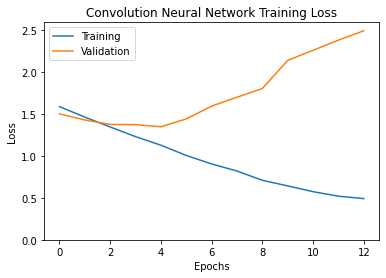

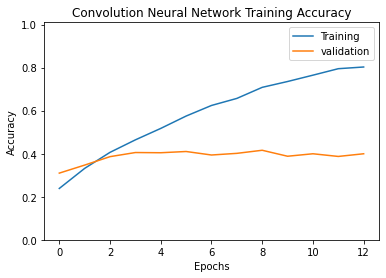

In [22]:
plt.title('Convolution Neural Network Training Loss')
plt.plot(cnn_history.history['loss'], label='Training')
plt.plot(cnn_history.history['val_loss'], label='Validation')
plt.ylim(bottom=0.0)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

plt.title('Convolution Neural Network Training Accuracy')
plt.plot(cnn_history.history['accuracy'], label='Training')
plt.plot(cnn_history.history['val_accuracy'], label='validation')
plt.ylim(bottom=0.0,top=1.01)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show();

In [23]:
## Save File: Task 7
import pickle

cnn_model_file_name = "cnn_model.pkl"
with open(cnn_model_file_name, "wb") as file:
    pickle.dump(cnn_model, file)

## Implementation - Task 5
Implement a Recurrent Neural Network (RNN) or a Long Short-Term Memory (LSTM) model for predicting the rating of a food review. The model must have at least two RNN/LSTM layers. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**12%**)

In [24]:
## LSTM Model will be using Pre-trained Embeddings
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization
import numpy as np

## Define Hyper Parameters
MAX_VOCABULARY_WORDS = 5000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 50 # Based on the file embedding
SCORE_CLASSES = 5 # Predictor Classes

## Initializer Tokenizer "Training Tokenizer"
tokenizer = Tokenizer(num_words = MAX_VOCABULARY_WORDS)
tokenizer.fit_on_texts(X_train)
word_indexes = tokenizer.word_index

## As we are using the tokenizer which is fit on the training for future models

## Convert text into sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

## Add Padding to make uniform length
X_train_padded = pad_sequences(X_train_sequences, 
                               maxlen = MAX_SEQUENCE_LENGTH, 
                               padding = "post")
X_test_padded = pad_sequences(X_test_sequences, 
                              maxlen = MAX_SEQUENCE_LENGTH, 
                              padding = "post")

## Vectorize Training Vocabulary
## Text -> Vocabulary Vector
vectorizer = TextVectorization(max_tokens = MAX_VOCABULARY_WORDS,
                                   output_sequence_length = MAX_SEQUENCE_LENGTH)
vectorizer.adapt(X_train)
vocabulary = vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary)))) # Create Indexes of words
print("Vocabulary size: " + str(len(vocabulary)) + " words.")

## Load Pre-trained Embeddings
## File is in the submission directory
embeddings_dict = {}
with open("glove.6B.50d.txt", "r") as file:
    counter = 1
    for line in file: # Each Line represent a vector of embeddings
        values = line.split() # Turn into a list
        word = values[0] # Get word
        vector = np.asarray(values[1:], "float32") # 1: end = embeddings
        embeddings_dict[word] = vector # Add into the dict

## Create Embedding Dict
hits = 0 # Word Exist in the Embedding
misses = 0 # Word Does not Exist in the Embedding
embedding_matrix = np.zeros((len(word_indexes) + 1, EMBEDDING_DIM))
for word, idx in word_index.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        hits += 1
    else:
        misses += 1
        
vocab_size = embedding_matrix.shape[0]
print("Converted %d words (%d misses)" % (hits, misses))

Vocabulary size: 5000 words.
Converted 4858 words (142 misses)


In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional

## Define the Model
lstm_model = Sequential(name="LSTM_model")

## Input Layer
lstm_model.add(Input(shape = (MAX_SEQUENCE_LENGTH,), dtype = tf.int32))

## Embedding Layer:
embedding_layer = Embedding(
    input_dim = vocab_size,
    output_dim = EMBEDDING_DIM,
    input_length = MAX_SEQUENCE_LENGTH,
    weights = [embedding_matrix],  # Pre-trained Embeddings
    trainable = False
)
lstm_model.add(embedding_layer)

## Hidden Layer: LSTM Model
lstm_model.add(Bidirectional(LSTM(32, return_sequences = True,
                                 seed = SEED)))
lstm_model.add(Bidirectional(LSTM(32, go_backwards = True, 
                                  dropout = 0.2,
                                 seed = SEED)))

## Dense Layer
lstm_model.add(Dense(32, activation='relu')) 
Dropout(rate=0.2, seed = SEED) 
lstm_model.add(Dense(32, activation='relu'))#016
Dropout(rate=0.1, seed = SEED) #0.2

## Output Layer: Multiclass Classification (n = 5) - SoftMax Activation
lstm_model.add(Dense(SCORE_CLASSES, activation = "softmax"))

## Get Model Summary
lstm_model.summary() # Print model summary

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           979500    
                                                                 
 bidirectional (Bidirection  (None, 100, 64)           21248     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 5)                 1

In [26]:
from tensorflow.keras.optimizers import Adam

EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.005

lstm_model_opt = Adam(learning_rate = LEARNING_RATE)

lstm_model.compile(loss = "sparse_categorical_crossentropy", 
                   optimizer = lstm_model_opt, 
                   metrics = ["accuracy"])

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early = EarlyStopping(monitor = "val_accuracy",
                      patience = 4,
                      restore_best_weights = True,
                      mode = "auto")

## For Reproducibility
keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

## Run the Model
lstm_history = lstm_model.fit(x = X_train_padded, 
                            y = Y_train_encoded,
                            epochs = EPOCHS, 
                            batch_size = BATCH_SIZE,
                            validation_split = 0.1,
                            callbacks=[early])

Epoch 1/20
295/295 [==============================] - 30s 85ms/step - loss: 1.5518 - accuracy: 0.2736 - val_loss: 1.4717 - val_accuracy: 0.3413
Epoch 2/20
295/295 [==============================] - 27s 91ms/step - loss: 1.4407 - accuracy: 0.3461 - val_loss: 1.3818 - val_accuracy: 0.3728
Epoch 3/20
295/295 [==============================] - 29s 98ms/step - loss: 1.3558 - accuracy: 0.3892 - val_loss: 1.3475 - val_accuracy: 0.4111
Epoch 4/20
295/295 [==============================] - 30s 102ms/step - loss: 1.2963 - accuracy: 0.4251 - val_loss: 1.2867 - val_accuracy: 0.4293
Epoch 5/20
295/295 [==============================] - 26s 90ms/step - loss: 1.2312 - accuracy: 0.4553 - val_loss: 1.2838 - val_accuracy: 0.4512
Epoch 6/20
295/295 [==============================] - 24s 80ms/step - loss: 1.1752 - accuracy: 0.4871 - val_loss: 1.2657 - val_accuracy: 0.4493
Epoch 7/20
295/295 [==============================] - 24s 80ms/step - loss: 1.1285 - accuracy: 0.5028 - val_loss: 1.2450 - val_accuracy

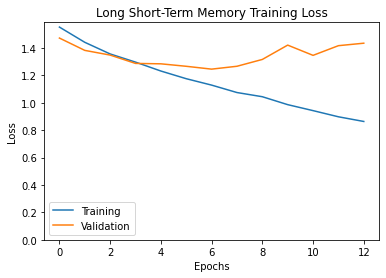

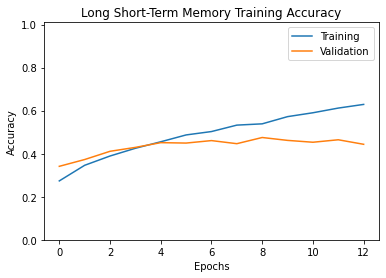

In [28]:
plt.title('Long Short-Term Memory Training Loss')
plt.plot(lstm_history.history['loss'], label='Training')
plt.plot(lstm_history.history['val_loss'], label='Validation')
plt.ylim(bottom=0.0)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

plt.title('Long Short-Term Memory Training Accuracy')
plt.plot(lstm_history.history['accuracy'], label='Training')
plt.plot(lstm_history.history['val_accuracy'], label='Validation')
plt.ylim(bottom=0.0,top=1.01)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show();

In [29]:
## Save File: Task 7
import pickle

lstm_model_file_name = "lstm_model.pkl"
with open(lstm_model_file_name, "wb") as file:
    pickle.dump(lstm_model, file)

## Implementation - Task 6
Compute the confusion matrix, accuracy, F1-score, precision and recall for each model. (10%)

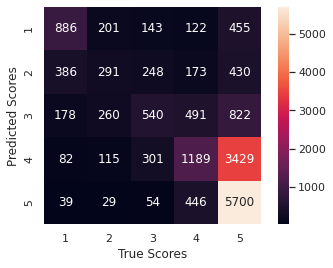

Naive Bayes Performance
Accuracy:	0.505938
F1-score:	0.409724
Precision:	0.411651
Recall:		0.465160

Classification performance:
              precision    recall  f1-score   support

           1       0.49      0.56      0.52      1571
           2       0.19      0.32      0.24       896
           3       0.24      0.42      0.30      1286
           4       0.23      0.49      0.32      2421
           5       0.91      0.53      0.67     10836

    accuracy                           0.51     17010
   macro avg       0.41      0.47      0.41     17010
weighted avg       0.69      0.51      0.55     17010



In [30]:
## Import Libraries
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

## Confusion Matrix for Naive Bayes
score_labels = ["1", "2", "3", "4", "5"]
nb_mat = confusion_matrix(Y_test, nb_pred_scores)
sns.heatmap(nb_mat.T, square = True, annot=True, fmt = "d", 
            xticklabels = score_labels, 
            yticklabels = score_labels)
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.show()

## Compute and print classification performance metrics
print("Naive Bayes Performance")
print("Accuracy:\t%f" % accuracy_score(Y_test, nb_pred_scores))
print("F1-score:\t%f" % f1_score(Y_test, nb_pred_scores, average='macro'))
print("Precision:\t%f" % precision_score(Y_test, nb_pred_scores, average='macro'))
print("Recall:\t\t%f" % recall_score(Y_test, nb_pred_scores, average='macro'))
print("\nClassification performance:\n%s" % classification_report(Y_test, nb_pred_scores))

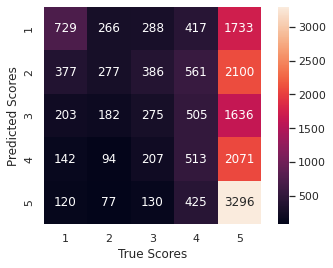

Best k-Nearest Neighbour Performance
Accuracy:	0.299236
F1-score:	0.235534
Precision:	0.273816
Recall:		0.300619

Classification performance:
              precision    recall  f1-score   support

           1       0.21      0.46      0.29      1571
           2       0.07      0.31      0.12       896
           3       0.10      0.21      0.13      1286
           4       0.17      0.21      0.19      2421
           5       0.81      0.30      0.44     10836

    accuracy                           0.30     17010
   macro avg       0.27      0.30      0.24     17010
weighted avg       0.57      0.30      0.35     17010



In [31]:
## Best K-NN Model Prediction

## Confusion Matrix for Best K-NN Model
score_labels = ["1", "2", "3", "4", "5"]
knn_mat = confusion_matrix(Y_test, knn_pred_scores)
sns.heatmap(knn_mat.T, square = True, annot=True, fmt = "d", 
            xticklabels = score_labels, 
            yticklabels = score_labels)
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.show()

## Compute and print classification performance metrics
print("Best k-Nearest Neighbour Performance")
print("Accuracy:\t%f" % accuracy_score(Y_test, knn_pred_scores))
print("F1-score:\t%f" % f1_score(Y_test, knn_pred_scores, average='macro'))
print("Precision:\t%f" % precision_score(Y_test, knn_pred_scores, average='macro'))
print("Recall:\t\t%f" % recall_score(Y_test, knn_pred_scores, average='macro'))
print("\nClassification performance:\n%s" % classification_report(Y_test, knn_pred_scores))

532/532 [==============================] - 1s 2ms/step


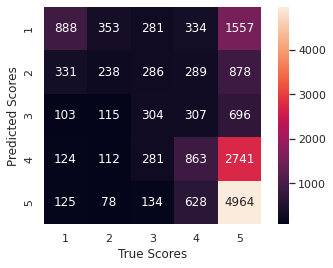

Convolution Neural Network Performance
Accuracy:	0.426631
F1-score:	0.318356
Precision:	0.324777
Recall:		0.376366

Classification performance:
              precision    recall  f1-score   support

           1       0.26      0.57      0.36      1571
           2       0.12      0.27      0.16       896
           3       0.20      0.24      0.22      1286
           4       0.21      0.36      0.26      2421
           5       0.84      0.46      0.59     10836

    accuracy                           0.43     17010
   macro avg       0.32      0.38      0.32     17010
weighted avg       0.61      0.43      0.47     17010



In [32]:
## Predicting CNN
cnn_pred_scores_prob = cnn_model.predict(X_test_padded)

## Decode It
scores_label_dict = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}
cnn_pred_scores = np.argmax(cnn_pred_scores_prob, axis=1) # Select the highest prob
cnn_pred_scores = cnn_pred_scores.tolist() # Change into list
cnn_pred_scores = [scores_label_dict[pred] for pred in cnn_pred_scores] # label it

## Confusion Matrix for Convolution Neural Network
score_labels = ["1", "2", "3", "4", "5"]
cnn_mat = confusion_matrix(Y_test, cnn_pred_scores)
sns.heatmap(cnn_mat.T, square = True, annot=True, fmt = "d", 
            xticklabels = score_labels, 
            yticklabels = score_labels)
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.show()

## Compute and print classification performance metrics
print("Convolution Neural Network Performance")
print("Accuracy:\t%f" % accuracy_score(Y_test, cnn_pred_scores))
print("F1-score:\t%f" % f1_score(Y_test, cnn_pred_scores, average='macro'))
print("Precision:\t%f" % precision_score(Y_test, cnn_pred_scores, average='macro'))
print("Recall:\t\t%f" % recall_score(Y_test, cnn_pred_scores, average='macro'))
print("\nClassification performance:\n%s" % classification_report(Y_test, cnn_pred_scores))

532/532 [==============================] - 13s 22ms/step


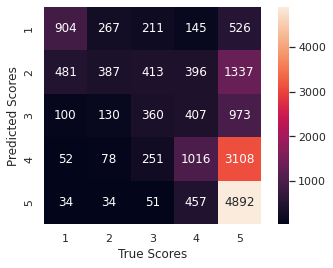

LSTM Neural Network Performance
Accuracy:	0.444386
F1-score:	0.362293
Precision:	0.374332
Recall:		0.431681

Classification performance:
              precision    recall  f1-score   support

           1       0.44      0.58      0.50      1571
           2       0.13      0.43      0.20       896
           3       0.18      0.28      0.22      1286
           4       0.23      0.42      0.29      2421
           5       0.89      0.45      0.60     10836

    accuracy                           0.44     17010
   macro avg       0.37      0.43      0.36     17010
weighted avg       0.66      0.44      0.50     17010



In [33]:
## Predicting LSTM
lstm_pred_scores_prob = lstm_model.predict(X_test_padded)

## Decode It
scores_label_dict = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}
lstm_pred_scores = np.argmax(lstm_pred_scores_prob, axis=1) # Select the highest prob
lstm_pred_scores = lstm_pred_scores.tolist() # Change into list
lstm_pred_scores = [scores_label_dict[pred] for pred in lstm_pred_scores] # label it

## Confusion Matrix for Convolution Neural Network
score_labels = ["1", "2", "3", "4", "5"]
lstm_mat = confusion_matrix(Y_test, lstm_pred_scores)
sns.heatmap(lstm_mat.T, square = True, annot=True, fmt = "d", 
            xticklabels = score_labels, 
            yticklabels = score_labels)
plt.xlabel("True Scores")
plt.ylabel("Predicted Scores")
plt.show()

## Compute and print classification performance metrics
print("LSTM Neural Network Performance")
print("Accuracy:\t%f" % accuracy_score(Y_test, lstm_pred_scores))
print("F1-score:\t%f" % f1_score(Y_test, lstm_pred_scores, average='macro'))
print("Precision:\t%f" % precision_score(Y_test, lstm_pred_scores, average='macro'))
print("Recall:\t\t%f" % recall_score(Y_test, lstm_pred_scores, average='macro'))
print("\nClassification performance:\n%s" % classification_report(Y_test, lstm_pred_scores))

In [34]:
## Previously We print each Model Individually
## Models
model_names = ["Naive Bayes", "k-Nearest Neighbor", "Convolution Neural Network", "Long Short-Term Memory"]
model_pred = [nb_pred_scores, knn_pred_scores, 
              cnn_pred_scores, lstm_pred_scores]

## Saved Parameters
model_accu = []
model_f1 = []
model_preci = []
model_recall = []

## loop to get data
for prediction in model_pred:
    model_accu.append(accuracy_score(Y_test, prediction))
    model_f1.append(f1_score(Y_test, prediction, average='macro'))
    model_preci.append(precision_score(Y_test, prediction, average='macro'))
    model_recall.append(recall_score(Y_test, prediction, average='macro'))

model_evaluation = {"model_name": model_names, 
                    "accuracy": model_accu, "F1": model_f1, 
                    "precision": model_preci, "recall": model_recall} 

model_comparision_df = pd.DataFrame(model_evaluation)

## Display to Compare the models
print("-" * 20 + " Overall Model Comparision " + "-" * 20 )
display(model_comparision_df)

-------------------- Overall Model Comparision --------------------


,model_name,accuracy,F1,precision,recall
0,Naive Bayes,0.505938,0.409724,0.411651,0.465160
1,k-Nearest Neighbor,0.299236,0.235534,0.273816,0.300619
2,Convolution Neural Network,0.426631,0.318356,0.324777,0.376366
3,Long Short-Term Memory,0.444386,0.362293,0.374332,0.431681


## Implementation - Task 7
Store the **four** trained models in files and implement a function `predict_food_review(text, model)` that given a <ins>text string</ins> (“`text`”) and model <ins>filename</ins> (“`model`”), it will load the pre-trained model, and predict the food review rating of the input text. The function should be able to work without requiring to rerun all or part of your code. (**10%**)

In [1]:
## Task 7.1.1: Save All the Models
## This was done after the creation of all the models.

## Task 7.2: Predict Based on saved Models
## This section Should Work by itself.

## Libraries Import
import pickle
import re
import numpy as np
from nltk import word_tokenize, sent_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_food_review(text, model_name):
    """
    Function that will get a text and will predict a model prediction score.
    """
    
    ## Define Parameters
    available_models = ["naive_bayes_model.pkl", "knn_model.pkl", "cnn_model.pkl","lstm_model.pkl"]
    MAX_SEQUENCE_LENGTH = 100
    PADDING = "post"
    scores_label_dict = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}
    
    ## Cleaning Process
    ## Cleaning Parameters
    wnl = WordNetLemmatizer() 
    punc_list = list(punctuation)
    stopwords_english = set(stopwords.words('english'))
    negative_stopwords = set(['no', 'nor', 'not', 'off'])
    updated_stopwords = stopwords_english - negative_stopwords
    
    ## Data Cleaning Functions
    def expand_contract_word(text):
        clean_text = text# Ensure consistency

        ## Specific Contractions
        ## With change in word form OR slight word modification
        clean_text = re.sub("won\'t", "will not", clean_text) # I won't -> i will not
        clean_text = re.sub("can\'t", "can not", clean_text) # I can't -> i can not
        clean_text = re.sub("shan\'t", "shall not", clean_text) # I shan't -> i shall not
        clean_text = re.sub("'cause", " because", clean_text) # 'cause -> because

        ## Without change in word form: couldn't, aren't,...
        clean_text = re.sub("n\'t", " not", clean_text)

        ## Present Tense Contraction 
        clean_text = re.sub("\'s", " is", clean_text) # It's -> it is [Generalize possible to be "has"]
        clean_text = re.sub("\'m", " am", clean_text) # I'm -> i am
        clean_text = re.sub("\'re", " are", clean_text) # They're -> they are

        ## Past Tense Contractraction
        clean_text = re.sub("\'ve", " have", clean_text) # I've -> i have

        ## Future Tense Contraction
        clean_text = re.sub("\'ll", " will", clean_text) # I'll -> i will
        clean_text = re.sub("\'d", " would", clean_text) # I'd -> i would

        ## Return the decontracted phrase
        return clean_text

    def star_replacer(match):
        score_range = {1: "one", 2: "two", 3: "three", 4: "four", 5: "five", 10: "ten"}
        num = int(match.group(1))  # Extract the captured number from the match
        if num in score_range:
            if num == 1: # If its a 1 star case
                return score_range[num] + " star" # Singular
            else:
                return score_range[num] + " stars"  # Plural Stars
        else:
            return str(num) + " stars"  # Other cases

    def star_rating_to_text(text):
        rating_regex = r"(1?[0-9])\s?[Ss]tars?" #Number follow by stars or star
        transformed_text = re.sub(rating_regex, star_replacer, text)
        return transformed_text
    
    def penn_to_wordnet(penn_pos_tag):
        tag_dictionary = {'NN':'n', 'JJ':'a','VB':'v', 'RB':'r'}
        try:
            return tag_dictionary[penn_pos_tag[:2]]
        except:
            return 'n'
    
    ## Regular Expression to clean the code
    clean_text = re.sub("[a-zA-Z0-9._+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", " ", text)
    clean_text = re.sub("<.*?>", " ", clean_text)
    clean_text = re.sub("(https?:\/\/|www\.){0,1}[a-zA-Z0-9]{2,}\.[a-zA-Z0-9]{2,}\S*", " ", clean_text) 
    clean_text = star_rating_to_text(clean_text)
    clean_text = expand_contract_word(clean_text)
    
    processed_review_text = list() # holder for a review
    for sent in sent_tokenize(clean_text): # Tokenize as a sentence
        tag_sentence = pos_tag(word_tokenize(sent)) # Give the sentences tagging
        for word, tag in tag_sentence:
            word = word.replace("-", "") # round-trip -> roundtrip
            word = word.replace(".", "") # U.S. -> US
            word = word.lower() # Change to lowercase
            word_matcher = re.match("[a-z]+", word) # a word should only be a list of characters
            if (word_matcher != None):
                if(word_matcher.group() == word): # If the detected word is the same with regex
                    ## A word should be two characters or more (e.g. no) and punctuation and not in the list of stop words 
                    if (len(word)>=2) and (word not in punc_list) and (word not in updated_stopwords):
                        processed_review_text.append(wnl.lemmatize(word, pos=penn_to_wordnet(tag)))

    cleaned_formatted_text = (" ".join(processed_review_text)).strip()
    
    ## Prediction
    pred_rating = None
    if model_name in available_models:
        with open(model_name, "rb") as model_file:
            selected_model = pickle.load(model_file)
        
        ## Select Text Processing Techniques Based on the Input
        processed_text = None # Placeholder
        
        if (model_name == "cnn_model.pkl") or (model_name == "lstm_model.pkl"):
            with open("tokenizer.pkl", "rb") as file:
                saved_tokenizer = pickle.load(file)
            clean_text = [cleaned_formatted_text]
            clean_text_seq = saved_tokenizer.texts_to_sequences(clean_text)
            processed_text = pad_sequences(clean_text_seq,
                                          maxlen = MAX_SEQUENCE_LENGTH,
                                          padding = PADDING)
            
#             file.close() # Close tokenier file
            
            pred_rating_prob = selected_model.predict(processed_text)
            pred_rating_idxs = np.argmax(pred_rating_prob, axis=1)
            pred_rating_ls = pred_rating_idxs.tolist()
            pred_rating = [scores_label_dict[pred] for pred in pred_rating_ls]
            
        else:
            ##
            processed_text = [cleaned_formatted_text] # Other cases
            pred_rating = selected_model.predict(processed_text) # As the TFIDF Already Implemented in the pipeline
        
        ## Predict the Rating
#         model_file.close() # Close Model File
        
        ## Visualize the Prediction
        print("-" * 50)
        print("Model Name:", model_name)
        print("-" * 50)
        print("Input Text:", text)
        print("Predicted Rating:", pred_rating[0])
        print("-" * 50 + "\n")
        
        return pred_rating
        
    else:
        print("-"*25 + " WARNING " + "-"*25)
        print("Please Input a Valid Model Name")
        print("Available Models Are:\n", available_models)
        print("-"*25 + " WARNING " + "-"*25)

In [2]:
## Testing the Input
print("\n< <- Bad Review Testing -> >")
fake_bad_review = "Very Bad, I hate it. I not going to recommend it for anyone." # Possible 1-2 Score
predict_food_review(fake_bad_review , "naive_bayes_model.pkl")
predict_food_review(fake_bad_review , "knn_model.pkl")
predict_food_review(fake_bad_review , "cnn_model.pkl")
predict_food_review(fake_bad_review , "lstm_model.pkl")

print("\n< <- Good Review Testing -> >")
fake_good_review = "Very Good product, I love it. I would recommended to anyone I know." # Possible 4-5 Score
predict_food_review(fake_good_review , "naive_bayes_model.pkl")
predict_food_review(fake_good_review , "knn_model.pkl")
predict_food_review(fake_good_review , "cnn_model.pkl")
predict_food_review(fake_good_review , "lstm_model.pkl")

print("\n< <- Not Exist Model -> >\n")
predict_food_review(fake_bad_review , "deep_learning_model.pkl") # Not Exist Model


< <- Bad Review Testing -> >
--------------------------------------------------
Model Name: naive_bayes_model.pkl
--------------------------------------------------
Input Text: Very Bad, I hate it. I not going to recommend it for anyone.
Predicted Rating: 1
--------------------------------------------------

--------------------------------------------------
Model Name: knn_model.pkl
--------------------------------------------------
Input Text: Very Bad, I hate it. I not going to recommend it for anyone.
Predicted Rating: 1
--------------------------------------------------

1/1 [==============================] - 0s 121ms/step
--------------------------------------------------
Model Name: cnn_model.pkl
--------------------------------------------------
Input Text: Very Bad, I hate it. I not going to recommend it for anyone.
Predicted Rating: 1
--------------------------------------------------

1/1 [==============================] - 1s 1s/step
----------------------------------------

## Report - Task 1
Critical discussion about the dataset (suitability, problems, class balance, etc.). (**6%**)

In this scenario, we are tasked with predicting food review scores through the review data set which contains three columns: Score, Summary, and Text, done by customers. The "Summary" provides the overall justification of the score and the "Text" elaborates on it. These two components represent the customer's justification for their rated score. Thus, for product rating prediction, this dataset is suitable to be used to build a prediction Model. However, it contains distortional high numbers of 5 rated scores compared to other classes. Therefore, we would address this class imbalance issue before the text data is used to train a machine-learning model within the pre-processing step. Directly using imbalanced data would result in a model that is biased towards predicting only a 5 rating. Additionally, we will remove duplicate rows that have all the same three columns to prevent overfitting and create a more generalized model. As this dataset is large at 540,031 reviews, we will be using a subset of data (15%) to build a smaller model to evaluate each modeling approach. Nevertheless, it should be noted that with multiple score classes and a small dataset, our ML models would potentially achieve low accuracy scores compared to large-scale models, as there are relatively fewer reviews and its vocabulary to represent all potential reviews.

<b> Words Count: </b> 215 words

## Report - Task 2
Description and justification of the data preparation step(s) used. (**6%**)

To prepare the data for modeling, we first combined the “Summary” and “Text” to keep all the information about the product review. Then we sampled a subset of data (15%) while maintaining the imbalanced class distribution. Subsequently, we will split the subset into 70% for training and 30% for testing data. This is to evaluate the model with the real-world score distribution. The training data is downsampled to the number of the lowest class to create a balanced dataset. Later, we apply the data processing function to both training and testing data before being used to build ML models. We are applying it after the test and train split as there would be some samples removed after downsampling, reducing processing time. The preparation consists of removing emails, URLs, and HTML tags, expanding the contracted word forms (e.g., isn’t to is not), replacing the user star rating with text to retain relevant text (e.g., 5 stars to five stars), and lemmatizing the text data. We select lemmatization over stemming as stemming would not maintain the part of speech that the word represents. In this case, we focus on keeping adjectives, which describe nouns, the products. Subsequently, we will convert words to lowercase and remove common stopwords. However, we will not remove some negative stopwords (e.g., not) as it could reflect the negative scores. Other truncated stopwords are not added to this negative stopwords list as we have previously expanded it. Additionally, punctuation marks are removed, and we filter out words that have a length of more than 2 in our cleaned text.

<b> Words Count: </b> 261 words

## Report - Task 3
Description and commentary on the machine learning architectures used, including a description and justification of the text representation method(s) used. (**7%**)

1.	<b> Naïve Bayes Model </b> <br>
Naïve Bayes is a probabilistic model based on Bayes’ theorem that assumes the independence between words within the review dataset, which aligns with the TF-IDF underlying assumption. Therefore, we select TF-IDF text representation. Additionally, it provides interpretability when compared to text embeddings, which is a dense text representation. We apply a pipeline to connect the TF-IDF vectorizer with the Naïve Bayes model.
<br>

2.	<b> k-Nearest Neighbor (k-NN) </b> <br>
For the k-NN model, we select TF-IDF text representation as it provides interpretability of how a word is considered in the context of this review dataset. The TF-IDF vectorizer is added into the model with make pipeline, which connects the processed text data from the training set into the k-NN model. With our goal to create a prediction model, we select the best k value based on average cross-validation (CV) accuracy. CV method splits the data into 3-folds evaluates the average accuracy and builds a model, reducing overfitting. In this report, we select k equals 7 as it produces the highest average performance among other k-values at 0.3074 accuracy.
<br>

3.	<b> Convolution Neural Network (CNN) </b> <br>
For the CNN model, we utilize Global Vectors for Word Representation (GloVe) pre-trained word embedding (glove.6B.50d) with 50 embeddings dimension (Pennington et al., 2014). This embedding provides a dense word representation, reducing the computational time for these deep-learning models. Despite the lack of interpretability compared to TF-IDF, word embeddings capture a semantic representation of words, which CNN could derive. In the CNN architecture. this embedding is utilized as a layer. Two subsequent one-dimensional convolution layers are selected to extract features. We selected a kernel size of 3 for convolution layers, as larger kernels could result in loss of information. These two layers are followed by a global pooling layer to reduce the dimensionality of the data. The pooled features are passed through classification layers made from two dense layers. In this layer, the dropout layer is added to improve generalization through the prevention of overfitting (Srivastava et al., 2014). The dense layer is connected to the output layer, which has a softmax activation function, which provides a probability for each output class within the dataset.
<br>

4.	<b> Long Short-Term Memory (LSTM) </b> <br>
For this section, we select the LSTM model over the Recurrent Neural Network as LSTM could capture the text data across the sequences of words. Similar to CNN, LSTM utilized the same word embedding as the CNN model to retain sematic representation and improve computation time. The LSTM architecture connects the embedding layer to two bidirectional LSTMs: forward and backward pass. These two layers are connected to the classification layer made from two dense layers. LSTM overfitting is reduced through the implementation of drop-out layers within these dense layers. The dense layer is connected to an output layer with softmax activation function.

<b> Words Count: </b> 466 words
<br>
<b> References </b> <br>
1. Pennington, J., Socher, R. and Manning, C.D. (2014) GloVe: Global Vectors for Word Representation, Glove: Global vectors for word representation. Available at: https://nlp.stanford.edu/projects/glove/ (Accessed: 13 March 2024).
2. Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: a simple way to prevent neural networks from overfitting. The journal of machine learning research, 15(1), 1929-1958.

## Report - Task 4
Detailed performance evaluation of the trained machine learning models in terms of the computed performance metrics. (**5%**)

For performance evaluation, we will focus on accurately predicting the correct class or the true positive cases for each rating, treating their importance equally. Therefore, we will be using macro averages of precision, recall, and its harmonic mean, F1-score, in addition to the accuracy score. This is due to the testing dataset containing disproportional instances of 5-rating compared to other ratings. As we using two text representation methods TF-IDF and word embeddings, we will first compare Naïve Bayes with k-NN performance and CNN and LSTM. Between Naïve Bayes and k-NN (7 neighbors), the Bayes model achieves higher macro average F1, precision, recall, and accuracy compared to k-NN this makes the Bayes model a more suitable model. For Bayes classification performance, 5-rating and 1-rating achieves 0.91 and 0.49 precision and the recall is 0.53 and 0.56, accordingly. This indicates that the model detects fewer results but when it does for 5-rating, it correctly predicted. This is represented in the confusion matrix where Bayes model where the model prediction matched the true labels for 5-rating.
On the other hand, for CNN and LSTM, It should be noted that subsequent training run produces high variance in prediction accuracy (testing). We suspect that this is a result of the non-deterministic behavior during model training. Overall, across multiple runs, the LSTM model achieves higher macro average F1, precision, recall, and accuracy compared to the CNN model. Similar to the Naïve Bayes model, LSTM model, 5-rating and 1-rating  classes have the highest precision with 1-rating have higher recalled compared to 5-rating. 

<b> Words Count: </b> 255 words

## Report - Task 5
Critical discussion on the achieved results, including potential limitations and usage instructions/suggestions. (**6%**)

From the achieved results, we identified that the Naïve Bayes, using TF-IDF, and LSTM, using pre-trained word embeddings, models perform better than their same text representation counterpart making them a suitable choice for this application. However, their overall performance are suboptimal to be deployed for this food rating according to the testing overall classes’ macro F1 and accuracy scores. This fact is especially true with the LSTM model, which theoretically could achieve better performance matrices than the Naïve Bayes through the word embeddings. However, our results revealed that both DL models have high variance in their prediction accuracy, hindering comparison. We attributed this to the non-deterministic behavior during training, which requires investigation. Furthermore, the DL training plot indicates that both models overfit towards the training data as the training accuracy grows with successive training epochs compared to validation accuracy. To tackle this issue, we suggest the use of data augmentation and regularization methods to make the model more generalized. Additionally, future modeling should consider using larger vocabulary size in the embeddings or self-trained embeddings models, as not all vocabulary in training data is being utilized due to being out-of-vocabulary in the pre-trained embeddings. As for high precision and recall for 1 and 5 rating categories across all the models, we hypothesized that it is due to the distinct vocabulary between these two extremes, resulting in high detection of true positive cases.

In conclusion, this report provides insights into the performance of four language models, we identified Naïve Bayes and LSTM models as potential models for this application. Still, it requires further exploration to address the existing limitations. To test these four models, a function called “predict_food_review” takes in the review text and the model file to predict the rating. If a model file does not exist, an error message will be printed.


<b> Words Count: </b> 302 words

<b> Total Report Words Count: </b> 1499 words (This excludes markdowns and references)